#First version of Convolutional AutoEncoder

## ReadMe

  - Computing modalities
  - Brief description of the goal of the NN
  - Calcul of loss ratio
  - Obtained results

##Data

In [1]:
import torch

In [2]:
#Import MNIST of handwritten digits dataset
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
#Loading the data
transform = transforms.Compose([transforms.CenterCrop(28),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
                                ])

#Train dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#Dataloader used to shuffle and create batch
train_loader   = torch.utils.data.DataLoader(mnist_trainset, batch_size=256, shuffle=True)
#Test dataset
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader   = torch.utils.data.DataLoader(mnist_testset, batch_size=256, shuffle=True)

In [4]:
def print_data_info(train_loader, test_loader):
    """
        Function to check on data
    """
    
    print("Nof train samples: ", len(train_loader.dataset))
    print("- samples' size: ", train_loader.dataset[0][0].shape)
    print("- batch size: ", train_loader.batch_size)
    print("\n")
    print("Nof test samples: ", len(test_loader.dataset))
    print("- samples' size: ", test_loader.dataset[0][0].shape)
    print("- batch size: ", test_loader.batch_size)

##Model

In [17]:
import torch.nn as nn

In [16]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        #Encoder part
        self.encoder_part = nn.Sequential(
            #Conv2d
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, bias=True),
            nn.ReLU(),
            #MaxPooling
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Conv2d
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, bias=True),
            nn.ReLU(),
        )

        #Decoder part
        self.decoder_part = nn.Sequential(
            #DeConv2d
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2, bias=True),
            nn.ReLU(),
            #Upsample
            nn.Upsample(size=(26,26)),
            #Conv2d
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=2),
        )

    def forward(self,x):

        #Encoder
        x = self.encoder_part(x)
        #Decoder
        x = self.decoder_part(x)

        return x

##Utils

In [7]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import random

In [8]:
def saveModel(model, file_path):
    """
        Function to save model's parameters
    """
    torch.save(model.state_dict(), file_path)


def loadModel(model, file_path, device):
    """
        Function to load function when only the params have been saved
    """
    params = torch.load(file_path)
    model.load_state_dict(params)


def checkPoint_model(model, 
                     optimizer, loss, epoch,
                     file_path):
    """
        Function to save model's checkpoints
    """
    
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss}, 
                file_path)

def load_checkPoint_model(model, optimizer, file_path, device):

    checkpoint = torch.load(file_path)

    #Loading
    model.load_state_dict(checkpoint['model_state_dict'], map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location=device)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss

def train_epoch(model, optimizer, criterion, 
                train_loader, 
                device):

    loss = 0.0

    for i, (images, labels) in enumerate(train_loader, 0):
        
            #Data send to device + requires_grad=True
            images, labels = Variable(images.to(device)), Variable(labels.to(device))
            #Zero the gradient 
            optimizer.zero_grad()
            #Predictions 
            predicted_images = model(images)
            predicted_images.to(device)
            #Loss
            loss = criterion(predicted_images, images)
            #print("training loss: ", loss)
            #Upgrade the gradients (backpropagate) and the optimizer
            loss.backward()
            optimizer.step()

    return loss


def validate_epoch(model, optimizer, criterion, 
                   test_loader, epoch,
                   device):
    
    losses          = []
    loss            = 0.0
    accuracy        = 0.0
    nof_predictions = 0.0

    #Fasten the inference by setting every requires_grad to False
    with torch.no_grad():
        for data in test_loader:
            #Get data and send them to the device
            images, _ = data
            images    = images.to(device)
            #Run the model on the test set
            outputs = model(images)
            outputs.to(device)
            #Compute the loss on the batch
            loss = criterion(images, outputs)
            #print("validation loss: ", loss)
            losses.append(loss)
    
    ###############################
    #  Definition of loss ratio r #
    ###############################
    #
    # loss ratio = loss / maximum loss theoritically possible
    # 
    # accuracy = 100*(1 - r)
    #
    # For further details on the calcul of the accuracy, one may refer to the ReadMe.me file 
    ###############################

    #With nomalization, max is 1 for tensors' values
    max_theorical_loss = (2*1)**2
    #Number of pixels in each images of dataset is test_loader.dataset[0][0].squeeze().numel()
    loss_ratio = sum(losses)/(max_theorical_loss * test_loader.dataset[0][0].squeeze().numel()) 
    accuracy = 100*(1 - loss_ratio)

    return accuracy

def train_model(model, train_loader, test_loader, 
                nof_epochs, optimizer, learning_rate, criterion, 
                file_path_save_model):
    
    #Which device + sending model to its memory
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    model.to(device)

    best_accuracy = 0.0

    for epoch in range(nof_epochs):

        epoch_accuracy = 0.0
        epoch_loss     = 0.0

        #Training
        model.train()
        epoch_loss = train_epoch(model, optimizer, criterion, 
                                 train_loader, 
                                 device)
        
        #Validation
        model.eval()
        epoch_accuracy = validate_epoch(model, optimizer, criterion, 
                                        test_loader, epoch,
                                        device)
        
        print('Epoch', epoch+1,', accuracy: {:.4f} % \n'.format(epoch_accuracy))
        
        #Save model when best accuracy is beaten
        if epoch_accuracy > best_accuracy:
            #load_checkPoint_model(model, optimizer, file_path_save_model, device)
            saveModel(model, file_path_save_model)
            best_accuracy = epoch_accuracy

    return model


def plot_results(model, test_loader,
                 device):
    """
    Display few images and outputs to compare them 
    """

    fig = plt.figure(figsize=(10,10))

    #Display 4*4=16 images
    for i in range(int(16/2)):

        #Select a random image in the dataset
        nof_images = len(test_loader.dataset)
        idx = random.randrange(nof_images)
        #Inference
        image = test_loader.dataset[idx][0].unsqueeze(0).to(device)
        with torch.no_grad():
            model.eval()
            rebuilt_image = model(image)
            #print(torch.max(model(image), 1).indices[0].item())
        #Sent back the image to the CPU
        image = image.squeeze().to('cpu')
        rebuilt_image = rebuilt_image.squeeze().to('cpu')

        #Plot

        ax_image = plt.subplot(4,4, 2*i+1 )
        ax_image.set_title("Real image")
        plt.imshow(image, cmap='gray_r')
        plt.axis('off')

        ax_rebuild_image = plt.subplot(4,4, 2*(i+1) )
        ax_rebuild_image.set_title("Rebuilt image")
        plt.imshow(rebuilt_image, cmap='gray_r')
        plt.axis('off')
    
    fig.suptitle("{} on few examples\n Reached accuracy with 15 epochs: 99.9862%".format(model.__class__.__name__))

    #Save
    plt.savefig(str(model.__class__.__name__) + "_accuraccy_99.9862" + ".pdf")

    #Show
    plt.show()



##Main

In [9]:
from torchsummary import summary
import torch

The model will be running on cuda:0 device
Epoch 1 , accuracy: 99.9463 % 

Epoch 2 , accuracy: 99.9701 % 

Epoch 3 , accuracy: 99.9763 % 

Epoch 4 , accuracy: 99.9793 % 

Epoch 5 , accuracy: 99.9810 % 



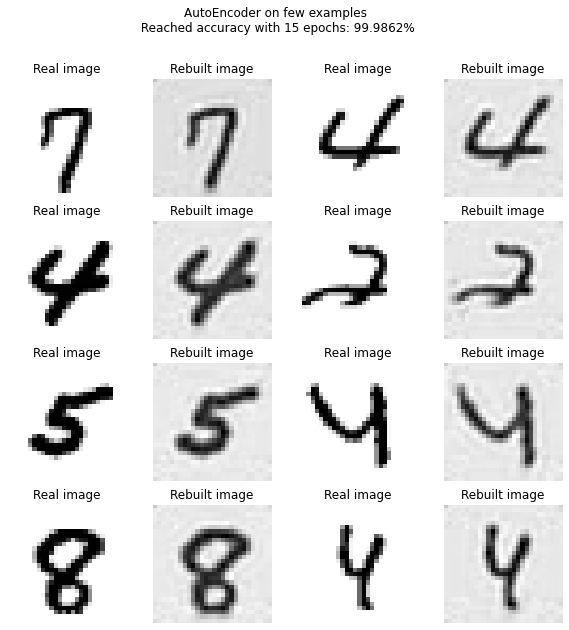

In [14]:
if __name__=="__main__":

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    #Instanciation of the model
    AE = AutoEncoder()
    AE.to(device)
    #summary(AE, (1, 28, 28))
    #print("\n")

    #Loading the data
    transform = transforms.Compose([transforms.CenterCrop(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5, std=0.5)
                                    ])

    #Train dataset
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    #Dataloader used to shuffle and create batch
    train_loader   = torch.utils.data.DataLoader(mnist_trainset, batch_size=256, shuffle=True)
    #Test dataset
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader   = torch.utils.data.DataLoader(mnist_testset, batch_size=256, shuffle=True)

    #Check data
    #print_data_info(train_loader, test_loader)

    #Training
    model = AE
    train_loader = train_loader
    test_loader  = test_loader
    nof_epochs = 5
    learning_rate = 0.001
    optimizer = torch.optim.Adam(AE.parameters(), lr = 0.001)
    criterion = torch.nn.MSELoss()
    file_path_save_model = '/content/checkpoint.pth'

    train_model(model, train_loader, test_loader, 
                nof_epochs, optimizer, learning_rate, criterion, 
                file_path_save_model)

    #Display results
    plot_results(AE, test_loader, device)
